In [1]:
# Importing necessary libraries

# Data preprocessing
import pandas as pd
import numpy as np
import os, librosa
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


# Model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
import numpy as np
import tensorflow_hub as hub
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import KFold

In [2]:
sample_audio = "input/classic/Angevin - Thatched Villagers - Kevin MacLeod.mp3"

## Data preprocessing and feature extraction

In [3]:
# Feature extraction
vggish = hub.load('https://tfhub.dev/google/vggish/1')

def vggish_extract(audiofile):
    y, sr = librosa.load(audiofile, sr = 44100)
    window = 20000
    stride = 5000
    total_time = librosa.get_duration(y = y, sr = sr)
    start = 0
    end = total_time * 1000
    return_list = []
    for i in range(start, int(end), stride):
        if i + window > end:
            break
        y_temp = y[i:i+window]
        feature = vggish(y_temp).numpy()
        
        if feature.shape[0] == 0:
            continue
        return_list.append(feature)
    return return_list

In [4]:
test = vggish_extract(sample_audio)
for i in test:
    print(i.shape)
    print("--------------------------")

(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
--------------------------
(1, 128)
-------------------

In [5]:
# Get the # of the file in each folder
for music_genre in os.listdir("input"):
    print(music_genre, "contains", len(os.listdir(f"input/{music_genre}")), "files")

classic contains 45 files
edm contains 47 files
hip hop contains 50 files
jazz and blue contains 50 files
pop contains 48 files
rock contains 49 files


In [6]:
# get the current working directory

folder_path = 'input'
class_num = len(os.listdir(folder_path))
data = []
cuurent_amount = 0
for genre in os.listdir(folder_path):
    for file in os.listdir(folder_path + '/' + genre):
        audio_file = folder_path + '/' + genre + '/' + file
        return_list = vggish_extract(audio_file)
        
        for i in return_list:
            for feature in i.tolist():
                feature.append(genre)
                data.append(feature)
    
        # print('File: {} is done'.format(file))
    #print the ammount of data extracted in each genre
    print('Genre: {} is done'.format(genre))
    print('The ammount of data extracted is {}'.format(len(data) - cuurent_amount))
    cuurent_amount = len(data)
    print('--------------------------------------')
              

    



Genre: classic is done
The ammount of data extracted is 1746
--------------------------------------
Genre: edm is done
The ammount of data extracted is 2313
--------------------------------------
Genre: hip hop is done
The ammount of data extracted is 1870
--------------------------------------
Genre: jazz and blue is done
The ammount of data extracted is 1308
--------------------------------------
Genre: pop is done
The ammount of data extracted is 1454
--------------------------------------
Genre: rock is done
The ammount of data extracted is 1963
--------------------------------------


In [7]:
# Converting the data into a pandas dataframe
data = pd.DataFrame(data, columns= ['vggish_{}'.format(i) for i in range(128)] + ['class'])
print(data.shape)
print(data.head())
# download the data as a csv file
data.to_csv('data.csv', index = True)


(10654, 129)
   vggish_0  vggish_1  vggish_2  vggish_3  vggish_4  vggish_5  vggish_6   
0 -0.383383 -0.063770  0.252886 -0.033248  0.058340 -0.314806 -0.279627  \
1 -0.291242  0.073546  0.312626 -0.053503 -0.065209 -0.365410 -0.070603   
2 -0.510353 -0.090235  0.327976 -0.310888 -0.142406 -0.465033 -0.166835   
3 -0.639021 -0.150224  0.266037 -0.326658 -0.300337 -0.546237 -0.341716   
4 -0.725290 -0.018930  0.227816 -0.402209 -0.293538 -0.540424 -0.282182   

   vggish_7  vggish_8  vggish_9  ...  vggish_119  vggish_120  vggish_121   
0  0.068904  0.041962 -0.476366  ...    0.124734   -0.154244   -0.088116  \
1  0.069611 -0.477838 -0.226981  ...    0.270841   -0.165910    0.179265   
2  0.019267 -0.330912 -0.308641  ...    0.426292   -0.223299    0.317010   
3 -0.130021 -0.565661 -0.324109  ...    0.715707   -0.232093    0.350469   
4 -0.036516 -0.373217 -0.219557  ...    0.710563   -0.385606    0.292337   

   vggish_122  vggish_123  vggish_124  vggish_125  vggish_126  vggish_127   
0 

In [8]:
# load the data form csv
# data = pd.read_csv('data.csv')

In [9]:
# divide the data into features and labels
x = data.iloc[:, :-1]
y = data.iloc[:, -1]


# encode the labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)
print(f"data shape x: {x.shape} y: {y.shape}")



data shape x: (10654, 128) y: (10654,)


In [10]:
# model evaluation
def evaluate_model(predictions, y_test):
    
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    precision = precision_score(y_test, predictions, zero_division=1, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    mcc = matthews_corrcoef(y_test, predictions)
    # auroc = roc_auc_score(y_test, predictions, multi_class= 'ovo')
    
    
    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall, 'mcc': mcc}

    

# Traditional model

In [18]:
models = {
    'knn': KNeighborsClassifier(n_neighbors = 1, algorithm= 'brute'),
    'svm': SVC(kernel= 'poly', degree= 6,tol= 0.001, coef0= 0.1 ,gamma= 'scale')
}


# Neural network model

In [19]:
NN = Sequential()
NN.add(Dense(128, input_dim=x.shape[1], activation='relu'))
NN.add(Dense(64, activation='relu'))
NN.add(Dense(class_num, activation='softmax'))
NN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [20]:
models["DNN"] = NN
print(NN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 25,158
Trainable params: 25,158
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
kf = KFold(n_splits= 10, shuffle=True, random_state=42)
result = []
for kf_idx, (train_idx, val_idx) in enumerate(kf.split(x)):
    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    for model_name, model in models.items():
        
        if model_name == 'DNN':
            model.fit(x_train, y_train, epochs=30, batch_size=32)
            predictions = np.argmax(model.predict(x_val), axis=1)
        else:
            model.fit(x_train, y_train)
            predictions = model.predict(x_val)
        fold_res = evaluate_model(predictions, y_val)
        fold_res['model'] = model_name
        fold_res['fold'] = kf_idx
        result.append(fold_res)
    

    




Epoch 1/30
300/300 [==============================] - 1s 1ms/step - loss: 1.3449 - accuracy: 0.4632
Epoch 2/30
300/300 [==============================] - 0s 1ms/step - loss: 1.0857 - accuracy: 0.5866
Epoch 3/30
300/300 [==============================] - 0s 1ms/step - loss: 0.9476 - accuracy: 0.6414
Epoch 4/30
300/300 [==============================] - 0s 936us/step - loss: 0.8507 - accuracy: 0.6829
Epoch 5/30
300/300 [==============================] - 0s 940us/step - loss: 0.7722 - accuracy: 0.7193
Epoch 6/30
300/300 [==============================] - 0s 946us/step - loss: 0.7087 - accuracy: 0.7427
Epoch 7/30
300/300 [==============================] - 0s 1ms/step - loss: 0.6533 - accuracy: 0.7612
Epoch 8/30
300/300 [==============================] - 0s 1ms/step - loss: 0.6069 - accuracy: 0.7812
Epoch 9/30
300/300 [==============================] - 0s 953us/step - loss: 0.5616 - accuracy: 0.7975
Epoch 10/30
300/300 [==============================] - 0s 987us/step - loss: 0.5264 - accura

# Result presentation

Cross-validation results: 
           model  accuracy        f1  precision    recall       mcc
26           DNN  0.982160  0.982371   0.983287  0.982160  0.978580
27           knn  0.860094  0.859146   0.859122  0.860094  0.831387
28           svm  0.769014  0.766158   0.775555  0.769014  0.723479
29           DNN  0.990610  0.990651   0.990968  0.990610  0.988728
30  DNN Average   0.940976  0.940789   0.942469  0.940976  0.928937
31  knn Average   0.861929  0.860928   0.861433  0.861929  0.833093
32  svm Average   0.760467  0.755032   0.766977  0.760467  0.711998
Confusion matrix for the each model: 


<Figure size 2000x2000 with 0 Axes>

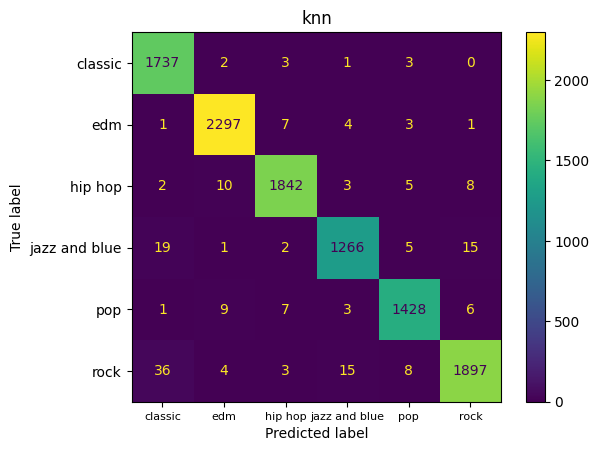

Confusion matrix for  knn  is saved as  knn.png


<Figure size 2000x2000 with 0 Axes>

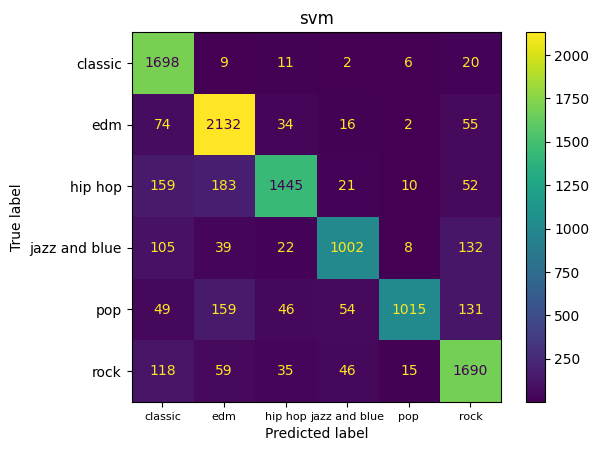

Confusion matrix for  svm  is saved as  svm.png
333/333 [==============================] - 0s 734us/step


<Figure size 2000x2000 with 0 Axes>

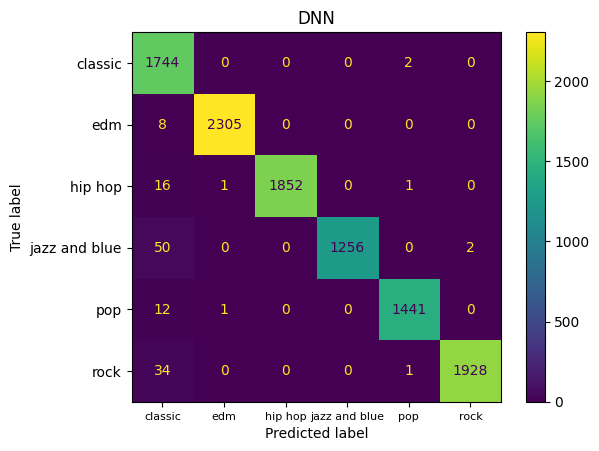

Confusion matrix for  DNN  is saved as  DNN.png


In [22]:
output_folder = 'result'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
else:
    # delete the existing files
    for file in os.listdir(output_folder):
        os.remove(output_folder + '/' + file)

cv_result_df = pd.DataFrame(result)
avg_result = cv_result_df.groupby('model').mean().reset_index()
avg_result['model'] += ' Average '
all_result_df = pd.concat([cv_result_df, avg_result], ignore_index=True)
all_result_df = all_result_df[['model', 'accuracy', 'f1', 'precision', 'recall', 'mcc']]


print("Confusion matrix for the each model: ")
for model_name, model in models.items():
    plt.figure(figsize=(20, 20))
    if model_name == 'DNN':
        predictions = np.argmax(model.predict(x), axis=1)
    else:
        predictions = model.predict(x)
    cm = confusion_matrix(y, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot()
    plt.title(model_name)
    plt.tick_params(axis='x', labelsize=8)
    plt.savefig(output_folder + '/' + model_name + '.png')
    plt.show()
    print("Confusion matrix for ", model_name, " is saved as ", model_name + '.png')

In [24]:
print("Cross-validation results: ")
print(all_result_df[-3:])
all_result_df.to_csv(output_folder + '/result.csv', index = False)

Cross-validation results: 
           model  accuracy        f1  precision    recall       mcc
30  DNN Average   0.940976  0.940789   0.942469  0.940976  0.928937
31  knn Average   0.861929  0.860928   0.861433  0.861929  0.833093
32  svm Average   0.760467  0.755032   0.766977  0.760467  0.711998
